In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import timeit
%matplotlib inline

In [2]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
DATA_PATH = 'R:/Angela/fast_trips/'
APC = os.path.join(DATA_PATH, '2015SampleDataSpring_6day.csv')
ROUTE = os.path.join(DATA_PATH, 'MuniRouteTypes.csv')
VEHICLES = os.path.join(DATA_PATH, 'Vehicles.csv')
FLEET = os.path.join(DATA_PATH, 'Copy of Fleet.csv')

In [4]:
OUT_PATH = 'R:/Angela/fast_trips/Dwell_test_4_26'
TRAIN = os.path.join(OUT_PATH, 'df_train.csv')
TEST = os.path.join(OUT_PATH, 'df_test.csv')
LM1_RESULTS = os.path.join(OUT_PATH, 'sklearn_results_VehcileDate.csv')
LM1_CORR = os.path.join(OUT_PATH, 'corrlation_table_VehcileDate.csv')
#LM2_RESULTS = os.path.join(OUT_PATH, 'sklearn_results_noVehicleDate.csv')
#LM2_CORR = os.path.join(OUT_PATH, 'corrlation_table_noVehcileDate.csv')

# options of samples

In [5]:
#Sample = pd.read_csv('R:/Angela/fast_trips/2015SampleDataSpring_6day.csv')
Sample = pd.read_csv(APC)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2868: DtypeWarning: Columns (72,75,77,83,117) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
Sample.shape

(494613, 120)

#my_data

In [7]:
my_data = Sample

In [8]:
#Or try a small sample if needed
'''
msk = np.random.rand(len(Sample)) < 0.95
my_data = Sample[~msk]
'''

'\nmsk = np.random.rand(len(Sample)) < 0.95\nmy_data = Sample[~msk]\n'

In [9]:
def data_content(data):
    data = data[['ON', 'OFF', 'VEHNO', 'ANAME', 'STOPA', 'YR', 'HR', 'MIN', 'SEC', 'DHR', 'DMIN', 'DSEC', 'ROUTE', 'LOAD', 'date_id']]
    return data

In [10]:
test = data_content(my_data)
test.shape

(494613, 15)

In [11]:
test.columns

Index([u'ON', u'OFF', u'VEHNO', u'ANAME', u'STOPA', u'YR', u'HR', u'MIN',
       u'SEC', u'DHR', u'DMIN', u'DSEC', u'ROUTE', u'LOAD', u'date_id'],
      dtype='object')

#Prepare bus info

In [12]:
#vehicles = pd.read_csv(r'R:\Angela\fast_trips\Vehicles.csv')
#fleet = pd.read_csv(r'R:\Angela\fast_trips\Copy of Fleet.csv')
vehicles = pd.read_csv(VEHICLES)
fleet = pd.read_csv(FLEET)

# Artic
vehicles.Artic = vehicles.Length.map({"60'" : 1, "40'" : 0, "30'" : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']

# Low Floor
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']

# Door
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']

# Capacity
vehicles.loc[:,'Total Capacity'] = pd.Series(vehicles['Total Capacity'], index=vehicles.index)
df_capacity = vehicles.set_index('Equip_Type').to_dict()['Total Capacity']
fleet['capacity'] = fleet['Equip_Type'].map(df_capacity)
df_vehnum_capacity = fleet.set_index('VehNum').to_dict()['capacity']

# Prepare route type

In [13]:
#route_type = pd.read_csv(r'R:\Angela\fast_trips\MuniRouteTypes.csv')
route_type = pd.read_csv(ROUTE)
route_type = route_type.dropna()
dict_route_type = {}
dict_route_type = route_type.set_index('APC Route ID')['Type'].to_dict()

#Step1: Prepare basic variables

In [14]:
def get_x_y(data):
    start = timeit.default_timer()
    # Before cleaning records, get the load data from the previous stop
    data['pre_load'] = data['LOAD'].shift()

    # Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['ON', 'OFF', 'VEHNO'])
    data = data[data['ON'] + data['OFF'] != 0]

    # COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    start = timeit.default_timer()
    data['COMPUTE_TIMESTOP'] = data['HR']*3600 + data['MIN']*60 + data['SEC']
    # COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data['DHR']*3600 + data['DMIN']*60 + data['DSEC']
    # COMPUTE DOORDWELL=DOORCLOSE - TIMESTOP
    data['COMPUTE_DOORDWELL'] = data['COMPUTE_DOORCOLSE'] - data['COMPUTE_TIMESTOP']
    # Appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 120]
    data = data[data['COMPUTE_DOORDWELL'] != 0]
    stop = timeit.default_timer()
    print 'compute dwell time:', stop - start

    # Keep rows that satisfy a query:
    start = timeit.default_timer()
    data['Doors'] = data['VEHNO'].map(df_vehnum_doors) 
    data['Artic'] = data['VEHNO'].map(df_vehnum_artic)
    data['Floor'] = data['VEHNO'].map(df_vehnum_floor)
    data['capacity'] = data['VEHNO'].map(df_vehnum_capacity)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    #data['all_door_boarding']= data.apply(lambda x: x['mo'] > 6, axis=1).map({False: 0, True: 1})
    
    # Create dummie variables for route id
    data['Route Type'] = data['ROUTE'].map(dict_route_type)
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    step_1.drop(['Local'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start

    # Create interaction variables
    start = timeit.default_timer()
    data['on_threedoors'] = data['ON']*data['three_doors']
    data['off_threedoors'] = data['OFF']*data['three_doors']
    data['on_floor'] = data['ON']*data['Floor']
    data['off_floor'] = data['OFF']*data['Floor']
    data['floor_threedoors'] = data['Floor']*data['three_doors']
    data['floor_twodoors'] = data['Floor']*data['two_doors']
    #data['on_all_door_boarding'] = data['ON']*data['all_door_boarding']
    #data['off_all_door_boarding'] = data['OFF']*data['all_door_boarding']
    data['on_express'] = data['ON']*data['Express']
    data['off_express'] = data['OFF']*data['Express']
    data['on_rapid'] = data['ON']*data['Rapid']
    data['off_rapid'] = data['OFF']*data['Rapid']
    data['on_owl'] = data['ON']*data['OWL']
    data['off_owl'] = data['OFF']*data['OWL']
    stop = timeit.default_timer()
    print 'add interaction variables:', stop - start

    return data

## Step2: Adding more passenger activity variables

In [15]:
def passenger_var(data):
    start = timeit.default_timer()
    data['max_pasg'] = data[['ON', 'OFF']].max(axis=1)
    print 'data shape:', data.shape
    data['abs_pasg'] = (data['ON'] - data['OFF']).abs()
    print 'data shape:', data.shape
    
    # A passenger friction factor was constructed to account for passenger activity on buses with standees. 
    # It was posited that heavily loaded buses have greater dwell times. 
    # STANDEES are the number of passengers when LOAD minus 60% of bus capacity is positive. 
    data['pre_standees']= data['pre_load'] - 0.60 * data['capacity']
    data['pre_crowding']= data.apply(lambda x: x['pre_standees'] > 0, axis=1).map({False: 0, True: 1})
    # A proxy variable was constructed by adding ONS, OFFS, and STANDEES.
    data['friction'] = ((data['ON'] + data['OFF'] + (data['pre_standees']).abs()) * data['pre_crowding']).abs()
    print 'data shape:', data.shape
    stop = timeit.default_timer()
    print 'add passenger activity variables:', stop - start

    # Remove the corner data, which is the first and last stop data
    start = timeit.default_timer()
    # COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['eol'] = data.apply(lambda x: '- EOL' in x['ANAME'], axis=1).map({False: 1, True: 0})
    # Remove the last stop
    data = data.loc[data['eol'] == 1]
    # Remove the first stop
    data = data.loc[data['STOPA'] != 1]
    stop = timeit.default_timer()
    print 'remove corner data:', stop - start
    
    return data

In [16]:
step1 = get_x_y(test)

compute dwell time: 0.127957466037
add veh&route info: 0.328335741575
add interaction variables: 0.0279338917315


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
step2 = passenger_var(step1)

data shape: (272383, 42)
data shape: (272383, 43)
data shape: (272383, 46)
add passenger activity variables: 3.99551333578
remove corner data: 4.11484248531


# Step3: Prepare vehicle ID variables

In [18]:
# Create dummie variables for bus id 
def create_vehID_day(data):
    start = timeit.default_timer()
    data['vehno_date'] = data.VEHNO.astype(str) + '_' + data.date_id.astype(str)
    #person_table['person_id'] = person_table.hh_id.astype(str) + '_' + person_table.pno.astype(str) 
    just_dummies_veh = pd.get_dummies(data['vehno_date'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    #step_1.drop([8515], inplace=True, axis=1)
    stop = timeit.default_timer()
    print 'data shape:', data.shape
    print 'add vehid&day variables:', stop - start
    
    return data

In [19]:
step3 = create_vehID_day(step2)

data shape: (270819, 991)
add vehid&day variables: 11.9522694268


In [20]:
step3.columns

Index([u'ON', u'OFF', u'VEHNO', u'ANAME', u'STOPA', u'YR', u'HR', u'MIN',
       u'SEC', u'DHR',
       ...
       u'8743_6', u'8744_1', u'8744_4', u'8744_5', u'8744_6', u'8745_4',
       u'8746_1', u'8746_4', u'8746_5', u'8750_1'],
      dtype='object', length=991)

# Step4: Delete a vehicle variable in each route type

In [21]:
# Get three dataframes for three bus type
test = step3
df_art = test.loc[test.Artic == 1]
df_std_low = test.loc[(test.Artic == 0) & (test.Floor == 1)]
df_std_high = test.loc[(test.Artic == 0) & (test.Floor == 0)]

In [22]:
# Get the bus IDs, who runs one route type in a day. 
def delet_dict_1(df):
    del_dict = {}
    df = df.dropna()
    print len(df)
    for veh_day in np.unique(df.vehno_date):
        df_veh = df.loc[df.vehno_date == veh_day]
        if (len(np.unique(df_veh['Route Type'])) == 1):
            rte_type = np.unique(df_veh['Route Type'])
            rte_type = str(rte_type)
            del_dict[rte_type] = veh_day
    print del_dict
    return del_dict

In [23]:
# Get the bus IDs, who runs three route types in a day. 
def delet_dict_3(df):
    del_dict = {}
    df = df.dropna()
    print len(df)
    for veh_day in np.unique(df.vehno_date):
        df_veh = df.loc[df.vehno_date == veh_day]
        if (len(np.unique(df_veh['Route Type'])) == 3):
            rte_type = np.unique(df_veh['Route Type'])
            rte_type = str(rte_type)
            del_dict[rte_type] = veh_day
    print del_dict
    return del_dict

In [24]:
print np.unique(df_art['Route Type'])
print np.unique(df_std_low['Route Type'])
print np.unique(df_std_high['Route Type'])

['Express' 'Local' 'Rapid']
['Express' 'Local' 'OWL' 'Rapid']
[nan 'Express' 'Local' 'Rapid']


C:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [25]:
print 'Articulated bus:'
del_art_1 = delet_dict_1(df_art)
print 'Standard bus with low floor:'
del_std_low_1 = delet_dict_1(df_std_low)
del_std_low_3 = delet_dict_3(df_std_low)
print 'Standard bus with high floor:'
del_std_high_1 = delet_dict_1(df_std_high)
del_std_high_3 = delet_dict_3(df_std_high)

Articulated bus:
66458
{"['Express']": '6403_1', "['Local']": '7123_1', "['Rapid']": '6403_6'}
Standard bus with low floor:
85341
{"['Rapid']": '8711_1', "['Local']": '8750_1', "['Express']": '8743_6'}
85341
{"['Local' 'OWL' 'Rapid']": '8721_4', "['Express' 'Local' 'OWL']": '8735_5', "['Express' 'Local' 'Rapid']": '8733_4'}
Standard bus with high floor:
117808
{"['Express']": '8231_3', "['Local']": '8228_1'}
117808
{"['Express' 'Local' 'Rapid']": '8221_1'}


In [26]:
# Create a dictionary that including the bus_day_id that need to be dropped
del_bus = {}
# Articulated bus
del_bus['Express1'] = '6403_1'
del_bus['Local1'] = '7123_1'
del_bus['Rapid1'] = '6403_6'
#Standard bus with low floor
del_bus['Express2'] = '8743_6'
del_bus['Local2'] = '8721_4' #Including Rapid2, OWL2
#Standard bus with high floor
del_bus['Express3'] = '8221_1' #including Local3 and Rapid3, no OWL in this type
print del_bus.values()

['6403_6', '8721_4', '7123_1', '6403_1', '8743_6', '8221_1']


In [27]:
print step3.shape
step4 = step3.drop(del_bus.values(), 1)
print step4.shape

(270819, 991)
(270819, 985)


In [28]:
#Delete data (dwell_time = 0) if needed
'''
step4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]
step4.shape
'''

"\nstep4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]\nstep4.shape\n"

In [29]:
# you may need drop some columns
#data = step4.drop(['Unnamed: 0'], axis = 1)
print 'step4 shape', step4.shape
data = step4
#drop the first row, since the NaN value
data = data[1:]
print 'data shape', data.shape

step4 shape (270819, 985)
data shape (270818, 985)


# Create training (70%) and validating (30%) dataset 

In [30]:
msk = np.random.rand(len(data)) < 0.7
df_train = data[msk]
df_test = data[~msk]

In [31]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [32]:
print df_train.shape
print df_test.shape

(188663, 985)
(80943, 985)


In [33]:
df_train.to_csv(TRAIN)
df_test.to_csv(TEST)

# Build multi-linear regression model

Model independent variables: 

alighting: [OFF], [ON]

fleet info: [Floor]

Vehcile type: [three_doors]:articulated or not

route type: [Express], [OWL], [Rapid]


# Model 1 - with vehicle ids

In [34]:
# Run Linear Regression In Python SciKit-Learn
#X[np.isnan(X)] = np.median(X[~np.isnan(X)])
X_train = df_train.drop(['COMPUTE_DOORDWELL','VEHNO','ANAME', 'STOPA', 'HR','MIN',
                         'SEC','ROUTE','YR','DHR','DMIN','DSEC','COMPUTE_TIMESTOP',
                         'COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors','two_doors', 
                         'Artic', 'Route Type', 'floor_threedoors', 'floor_twodoors', 
                         'pre_standees', 'pre_crowding','capacity', 'LOAD', 'pre_load', 
                         'vehno_date', 'date_id', 'eol', 'max_pasg', 'abs_pasg', 'friction'], axis=1)
y_train = df_train.COMPUTE_DOORDWELL

X_test = df_test.drop(['COMPUTE_DOORDWELL','VEHNO','ANAME', 'STOPA', 'HR','MIN',
                       'SEC','ROUTE','YR', 'DHR','DMIN','DSEC','COMPUTE_TIMESTOP',
                       'COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors','two_doors', 
                       'Artic', 'Route Type', 'floor_threedoors', 'floor_twodoors', 
                       'pre_standees', 'pre_crowding','capacity', 'LOAD', 'pre_load', 
                       'vehno_date', 'date_id', 'eol','max_pasg', 'abs_pasg', 'friction'], axis=1)
y_test = df_test.COMPUTE_DOORDWELL

In [35]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)
stop = timeit.default_timer()
print 'Time that build model with veh&day ids:', stop - start

Time that build model with veh&day ids: 14.4226737126


In [36]:
# R-square
R2 = r2_score(y_train, pred_train) 
print 'R^2: ', R2
print 'Estimated intercept coefficient:', lm1.intercept_
print 'Number of coefficients:', len(lm1.coef_)

R^2:  0.272055104257
Estimated intercept coefficient: 6.34641943488
Number of coefficients: 954


In [37]:
# Construct a data frame that contains features and estimated coefficients
sklearn_results1 = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results1['pvalues'] = pd.DataFrame(pvalues)
sklearn_results1['scores'] = pd.DataFrame(scores)
print sklearn_results1

           features  estimatedCoefficients  pvalues     scores
0                ON                  2.370    0.000 199897.611
1               OFF                  1.667    0.000  96536.955
2             Floor                  2.814    0.000   3646.381
3       three_doors                  5.307    0.000   1859.292
4           Express                  0.739    0.000    428.394
5               OWL                 -1.040    0.000    340.279
6             Rapid                  2.371    0.000   2611.483
7     on_threedoors                 -0.486    0.000  91687.860
8    off_threedoors                 -0.456    0.000  51458.415
9          on_floor                 -0.325    0.000  32480.108
10        off_floor                 -0.312    0.000  13840.357
11       on_express                 -0.335    0.000  13547.188
12      off_express                 -0.344    0.000  14201.938
13         on_rapid                 -0.213    0.000  57697.480
14        off_rapid                 -0.309    0.000  35

In [38]:
# Find out the variables whoes coefficients are bigger than 10 or smaller than -10 
i = 0
for value in sklearn_results1.estimatedCoefficients:
    if abs(value) > 10:
        print sklearn_results1[sklearn_results1.estimatedCoefficients == value]
        i += 1
print ''
print '--------------------------------------------------------'
print 'Number of coefficients, which value is larger than 10:', i

   features  estimatedCoefficients  pvalues  scores
32   5449_1                 10.440    0.000 237.855
   features  estimatedCoefficients  pvalues  scores
42   5450_6                 12.720    0.000 357.400
   features  estimatedCoefficients  pvalues  scores
75   5460_1                 10.679    0.000 209.537
   features  estimatedCoefficients  pvalues  scores
97   5464_6                 11.367    0.000 262.143
    features  estimatedCoefficients  pvalues  scores
118   5469_3                 11.112    0.000 360.387
    features  estimatedCoefficients  pvalues  scores
122   5470_4                 18.604    0.000 567.524
    features  estimatedCoefficients  pvalues  scores
146   5476_5                 12.267    0.000 295.304
    features  estimatedCoefficients  pvalues  scores
148   5477_2                 10.297    0.000 270.995
    features  estimatedCoefficients  pvalues  scores
196   5489_3                 11.074    0.000 350.773
    features  estimatedCoefficients  pvalues  scores
2

In [39]:
sklearn_results1.to_csv(LM1_RESULTS)

# Correlation table 1

In [40]:
c = X_train.corr().abs()
s = c.unstack()
so = s.order(kind="quicksort")

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


In [41]:
so.to_csv(LM1_CORR)

Find correlations larger than 0.5 

In [42]:
print 'Total number of correlation:', len(so)
soo = so.dropna()
soo = soo[soo >= 0.500]
soo = soo[soo != 1.0]
print 'Number of correlations larger than 0.5:', len(soo)

Total number of correlation: 910116
Number of correlations larger than 0.5: 24


In [43]:
soo

on_floor        Floor            0.505
Floor           on_floor         0.505
off_floor       Floor            0.507
Floor           off_floor        0.507
off_express     Express          0.515
Express         off_express      0.515
three_doors     on_threedoors    0.542
on_threedoors   three_doors      0.542
three_doors     off_threedoors   0.557
off_threedoors  three_doors      0.557
on_express      Express          0.566
Express         on_express       0.566
on_threedoors   ON               0.570
ON              on_threedoors    0.570
OFF             off_threedoors   0.571
off_threedoors  OFF              0.571
off_owl         OWL              0.578
OWL             off_owl          0.578
on_rapid        Rapid            0.617
Rapid           on_rapid         0.617
                off_rapid        0.631
off_rapid       Rapid            0.631
OWL             on_owl           0.632
on_owl          OWL              0.632
dtype: float64

# Plots 1 - Residual

In [45]:
# Pre-check whether there is any negative value in (y_train)
c = 0
for ele in y_train:
    if ele < 0:
        print ele
        c += 1
if c == 0:
    print 'there is no nagative value in y_tain'

there is no nagative value in y_tain


In [46]:
# Pre-check whether there is any negative value in lm.predict(X_train), and how many
'''
neg_dict = {}
j = 0
for ele in range(1, len(X_train)):
    i = ele-1
    #print i
    if lm1.predict(X_train[i:ele])<0: 
        neg_dict[ele] = lm1.predict(X_train[i:ele])
        j += 1
print j
'''

'\nneg_dict = {}\nj = 0\nfor ele in range(1, len(X_train)):\n    i = ele-1\n    #print i\n    if lm1.predict(X_train[i:ele])<0: \n        neg_dict[ele] = lm1.predict(X_train[i:ele])\n        j += 1\nprint j\n'

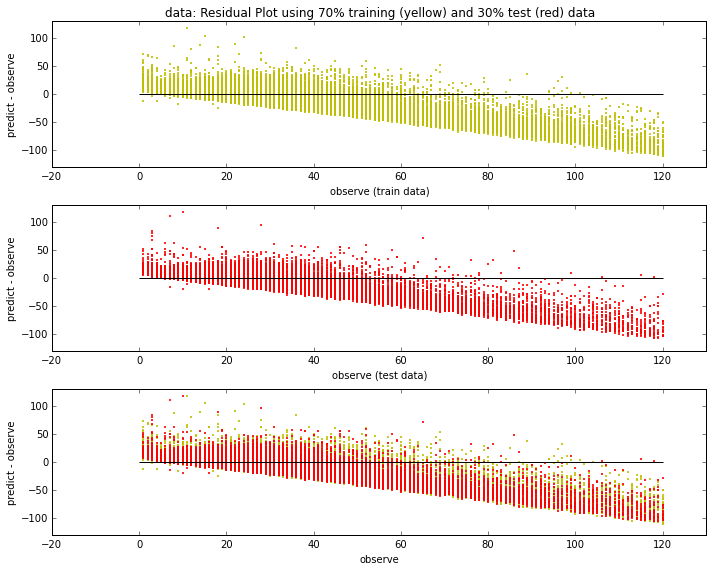

In [47]:
plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.tight_layout()
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()


# Plot 2: Trend line

In [51]:
df_est = []
df_est = pd.DataFrame(lm1.predict(X_test), index = X_test.index, columns = ['Dwell_Time_Esti'])
test = pd.concat([X_test, df_est], axis=1, join='inner')
test['on+off'] = test['ON'] + test['OFF']
test.columns

Index([u'ON', u'OFF', u'Floor', u'three_doors', u'Express', u'OWL', u'Rapid',
       u'on_threedoors', u'off_threedoors', u'on_floor',
       ...
       u'8744_1', u'8744_4', u'8744_5', u'8744_6', u'8745_4', u'8746_1',
       u'8746_4', u'8746_5', u'8750_1', u'Dwell_Time_Esti'],
      dtype='object', length=955)

In [58]:
test_artic = test[test.three_doors == 1]
test_std = test[test.three_doors == 0]
test_low = test[test.Floor == 1]
test_exp = test[test.Express == 1]
test_rapid = test[test.Rapid == 1]
test_owl = test[test.OWL == 1]
test_local = test[(test.Express != 1) & (test.OWL != 1) & (test.Rapid != 1)]

19888 19888


C:\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


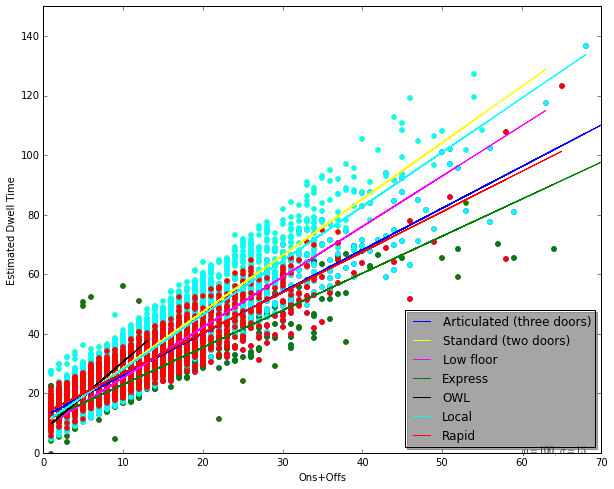

In [59]:
fig, ax = plt.subplots()

# Articulated bus
x1 = test_artic['on+off']
y1 = test_artic['Dwell_Time_Esti']
print len(x1), len(y1)
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Articulated (three doors)')

#Standard bus
x2 = test_std['on+off']
y2 = test_std['Dwell_Time_Esti']
ax.scatter(x2, y2, color = 'yellow')
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='yellow', label='Standard (two doors)')

#Low floor
x7 = test_low['on+off']
y7 = test_low['Dwell_Time_Esti']
ax.scatter(x7, y7, color = 'magenta')
fit = np.polyfit(x7, y7, deg=1)
ax.plot(x7, fit[0] * x7 + fit[1], color='magenta', label= 'Low floor')

#Express
x4 = test_exp['on+off']
y4 = test_exp['Dwell_Time_Esti']
ax.scatter(x4, y4, color = 'green')
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='green', label= 'Express')

#OWL
x5 = test_owl['on+off']
y5 = test_owl['Dwell_Time_Esti']
ax.scatter(x5, y5, color = '0.75')
fit = np.polyfit(x5, y5, deg=1)
ax.plot(x5, fit[0] * x5 + fit[1], color='black', label= 'OWL')

#Local
x6 = test_local['on+off']
y6 = test_local['Dwell_Time_Esti']
ax.scatter(x6, y6, color = 'cyan')
fit = np.polyfit(x6, y6, deg=1)
ax.plot(x6, fit[0] * x6 + fit[1], color='cyan', label= 'Local')

#Rapid
x8 = test_rapid['on+off']
y8 = test_rapid['Dwell_Time_Esti']
ax.scatter(x8, y8, color = 'red')
fit = np.polyfit(x8, y8, deg=1)
ax.plot(x8, fit[0] * x8 + fit[1], color='red', label= 'Rapid')

plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

#three doors trend is exactly as same as rapid ride bus... 

# Plot 3: Density scatter, observed V.S. y_predicted

# Traning dataset

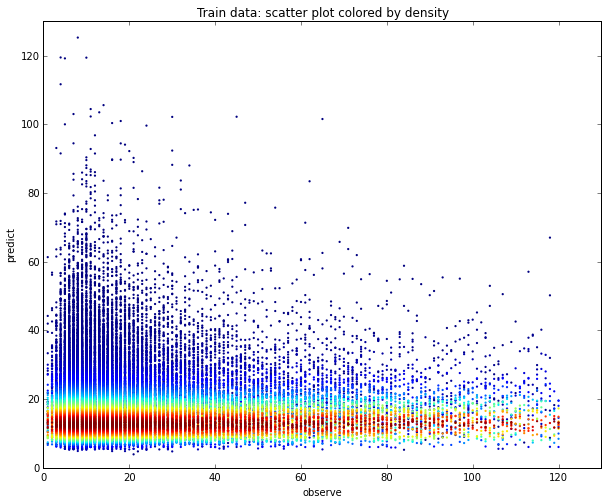

In [62]:
x = y_train
y = lm1.predict(X_train)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()

x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, edgecolor='')
plt.axis([0, 130, 0, 130])
plt.title('Train data: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()


# Testing data

finished calculating z: 298.483436258
finished sorting data: 0.00707410270479


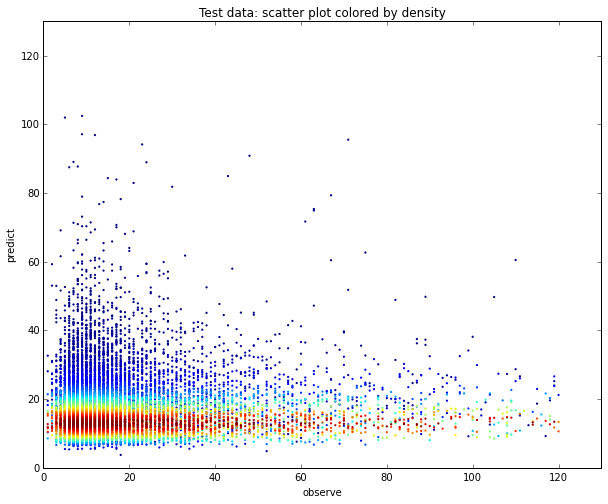

In [60]:
x = y_test
y = lm1.predict(X_test)

# Calculate the point density
start = timeit.default_timer()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
stop = timeit.default_timer()
print 'finished calculating z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z.argsort()
stop = timeit.default_timer()
print 'finished sorting data:', stop - start

x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, edgecolor='')
plt.axis([0, 130, 0, 130])
plt.title('Test data: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()


In [61]:
print 'end'

end
